In [1]:
import os, sys
sys.path.append('..')
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import json

from sklearn.manifold import TSNE
from skimage.io import imread, imsave

from datasets import dataset as dataset
from models.nn import ResNet_18 as ConvNet
from learning.evaluators import ErrorRateEvaluator as Evaluator

from models.utils import grad_cam, get_feature_maps

from datasets.utils import view_image_cam_pairs

In [2]:
image_save_dir = './images'

In [5]:
""" Load dataset """
#root_dir = ('../../original') # FIXME
root_dir = ('/Data/emnist/balanced/original') # FIXME

In [6]:
anno_path = os.path.join(root_dir, 'annotation', 'annotation1.json')
with open(anno_path, 'r') as fid:
    anno_dict = json.load(fid)
cls_list = anno_dict['classes'].values()
print(cls_list)

dict_values(['n', 'B', '9', 't', '6', 'b', 'U', '3', 'r', 'N', 'D', 'Z', 'Q', 'X', '5', 'f', 'F', '8', 'M', 'P', 'O', 'T', 'V', '4', '0', 'I', 'L', 'R', 'G', 'A', '7', 'W', 'd', '1', 'h', 'J', 'E', 'a', 'H', 'e', 'K', 'S', 'C', '2', 'Y', 'q', 'g'])


In [7]:
for i in range(len(anno_dict['classes'])):
    print(i, anno_dict['classes'][str(i)])

0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9
10 A
11 B
12 C
13 D
14 E
15 F
16 G
17 H
18 I
19 J
20 K
21 L
22 M
23 N
24 O
25 P
26 Q
27 R
28 S
29 T
30 U
31 V
32 W
33 X
34 Y
35 Z
36 a
37 b
38 d
39 e
40 f
41 g
42 h
43 n
44 q
45 r
46 t


In [8]:
imset_path = os.path.join(root_dir, 'imageset','imageset1')

file_list = []
for txt in ['train1.txt','validation1.txt','test.txt']:
    with open(os.path.join(imset_path,txt)) as fid:
        tmp = fid.read().split('\n')[:-1]
        file_list += tmp

print('모든 데이터셋 크기:',len(file_list))

모든 데이터셋 크기: 131598


L : 2800
9 : 2800
6 : 2800
P : 2800
S : 2800
3 : 2800
G : 2800
f : 2800
e : 2800
a : 2800
0 : 2800
Z : 2800
K : 2800
g : 2799
5 : 2800
d : 2800
8 : 2800
n : 2800
q : 2800
N : 2800
H : 2800
U : 2800
h : 2800
M : 2800
Y : 2800
Q : 2800
O : 2800
E : 2800
I : 2800
C : 2800
J : 2800
V : 2800
7 : 2800
b : 2800
1 : 2800
F : 2800
W : 2800
t : 2800
X : 2800
D : 2800
2 : 2800
T : 2800
R : 2800
4 : 2800
B : 2800
r : 2799
A : 2800


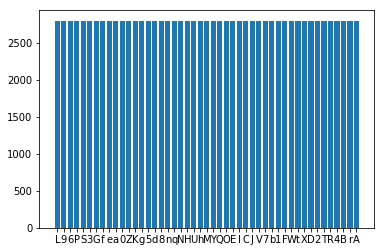

In [9]:
dic = {cls:[] for cls in cls_list}

for file in file_list:
    cls = file.split('_')[1]
    dic[cls].append(file)

y =[]
x = []
for cls in dic.keys():
    print(cls,':',len(dic[cls]))
    x.append(cls); y.append(len(dic[cls]))

plt.bar(range(len(x)),y, tick_label=x)
plt.show()
plt.savefig(os.path.join(image_save_dir,'class_bar.png'))

dict_keys(['L', '9', '6', 'P', 'S', '3', 'G', 'f', 'e', 'a', '0', 'Z', 'K', 'g', '5', 'd', '8', 'n', 'q', 'N', 'H', 'U', 'h', 'M', 'Y', 'Q', 'O', 'E', 'I', 'C', 'J', 'V', '7', 'b', '1', 'F', 'W', 't', 'X', 'D', '2', 'T', 'R', '4', 'B', 'r', 'A'])


<Figure size 432x288 with 0 Axes>

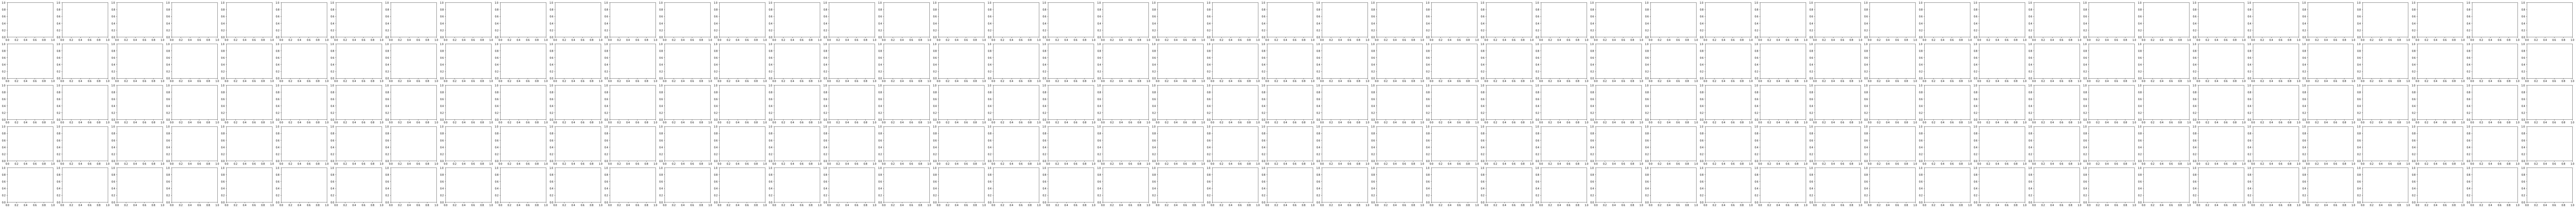

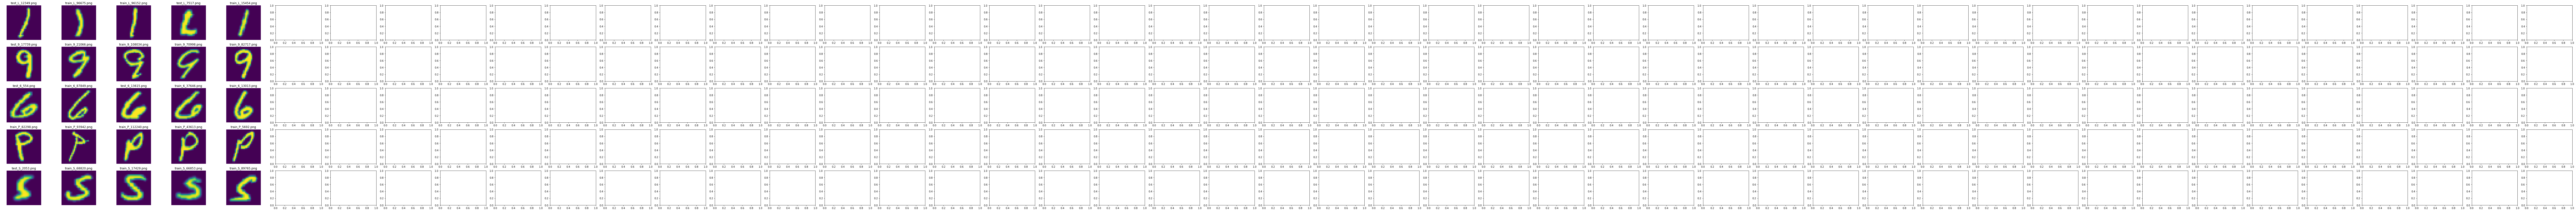

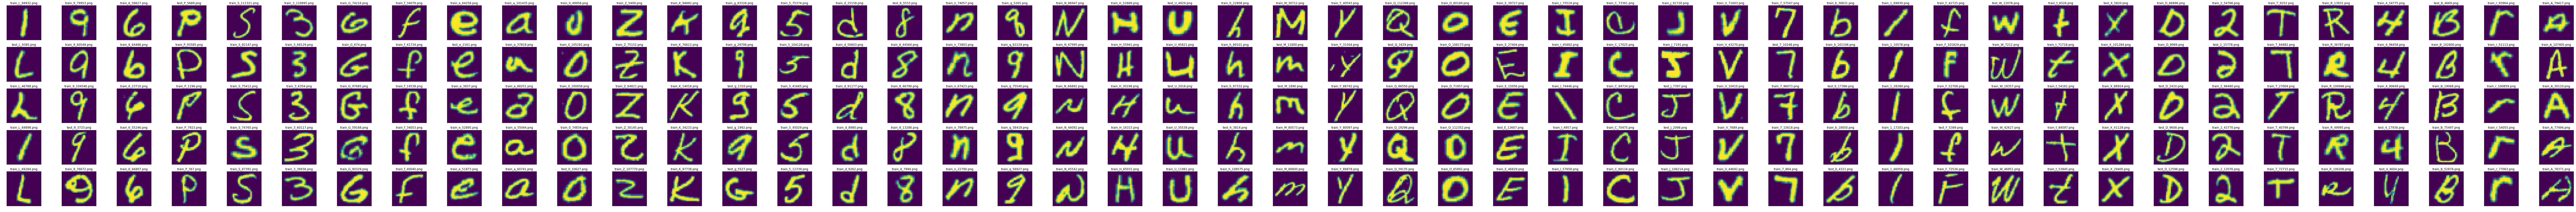

In [12]:
n_rows = 5
n_cols = len(dic.keys())
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols,3*n_rows))

print(dic.keys())

for j in range(n_cols):
    c = list(dic.keys())[j]
    samples = np.random.choice(dic[c], size=n_rows, replace=False)
    for i in range(n_rows):
        filename = samples[i]
        file_path = os.path.join(root_dir, 'image', filename)
        image = imread(file_path)
        _ = axes[i, j].imshow(image)
        _ = axes[i, j].axis('off')
        _ = axes[i, j].set_title(filename)

#plt.show()
plt.savefig(os.path.join(image_save_dir, 'item_samples.png'), bbox_inches='tight')
plt.show()

dict_keys(['L', 'X', 'n', 'B', 'T', 'C', 'K', 'N', '7', 'H', 'A', 'W', 'Y', '8', 'e', 'h', 'Z', 'R', 'Q', '0', 'd', 'g', 't', 'O', '2', '4', 'I', '1', 'F', '6', 'P', 'r', '3', 'q', 'V', 'S', 'a', 'U', 'M', '9', 'D', 'f', '5', 'E', 'b', 'J', 'G'])


<Figure size 432x288 with 0 Axes>

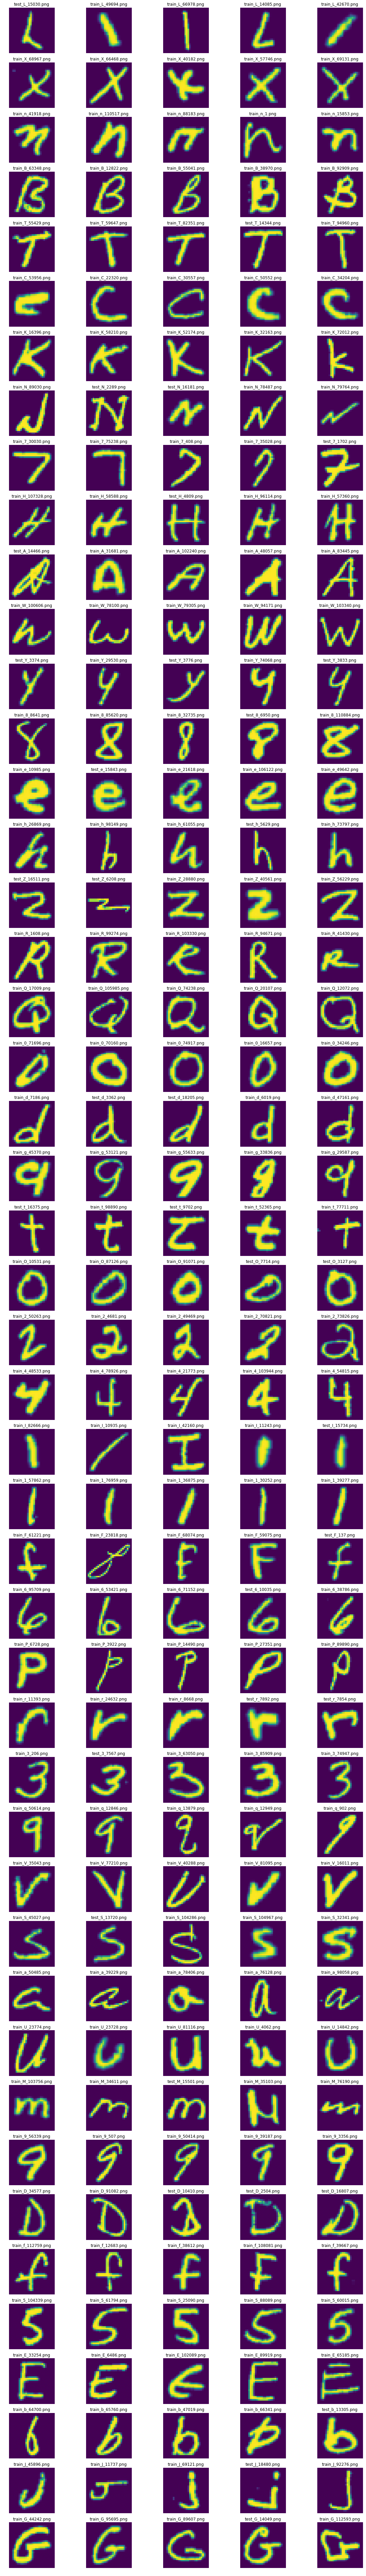

In [8]:
n_rows = len(dic.keys())
n_cols = 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols,3*n_rows))

print(dic.keys())

for j in range(n_rows):
    c = list(dic.keys())[j]
    samples = np.random.choice(dic[c], size=n_cols, replace=False)
    for i in range(n_cols):
        filename = samples[i]
        file_path = os.path.join(root_dir, 'image', 'balanced', filename)
        image = imread(file_path)
        _ = axes[j, i].imshow(image)
        _ = axes[j, i].axis('off')
        _ = axes[j, i].set_title(filename)

#plt.show()
plt.savefig(os.path.join(image_save_dir, 'item_samples.png'), bbox_inches='tight')
plt.show()

In [9]:
# mean: [ 0.17395425  0.17395425  0.17395425] (0.75)
# epoch 100이면 충분

In [10]:
# Load test set
test_list, anno_dict = dataset.read_data_subset(root_dir, mode='test')
test_set = dataset.Dataset(root_dir, test_list, anno_dict)

In [11]:
""" Set test hyperparameters """
hp_d = dict()
mean = np.array([0.17395425, 0.17395425, 0.17395425], dtype=np.float32)
image_mean = np.transpose(np.tile(mean,(224,224,1)),[2,0,1])
hp_d['image_mean'] = image_mean

# Test hyperparameters
hp_d['batch_size'] = 256

In [12]:
""" Load weights and start test """
model = ConvNet([3, 224, 224], len(anno_dict['classes']), **hp_d)
model.logits.restore('/Data/checkpts/model_fold_1_trainval_ratio_1.0.dnn') # FIXME
evaluator = Evaluator()
start_time = time.time()
ys, y_preds, test_score, confusion_matrix = model.predict(test_set, **hp_d)

total_time = time.time() - start_time

/home/hwehee/anaconda3/envs/cntk/lib/python3.5/site-packages/cntk/core.py:82: RuntimeWarning: data is not C contiguous; rearrange your data/computation to avoid costly data conversions
  RuntimeWarning)


conv1.shape (64, 112, 112)
pool1.shape (64, 56, 56)
conv2_2.shape (64, 56, 56)
conv3_2.shape (128, 28, 28)
conv4_2.shape (256, 14, 14)
conv5_2.shape (512, 7, 7)
pool6.shape (512, 1, 1)


In [13]:
print('Test error rate: {}'.format(test_score))

Test error rate: 0.10786795029827125


In [14]:
print('Total tack time(sec): {}'.format(total_time))
print('Tact time per image(sec): {}'.format(total_time / len(test_list)))

Total tack time(sec): 14.70421838760376
Tact time per image(sec): 0.0007821808813023969


In [15]:
print('Confusion matrix: \n{}'.format(confusion_matrix))
print('Remind:')
for i in range(len(anno_dict['classes'])):

    print(i,anno_dict['classes'][str(i)])

Confusion matrix: 
[[264   0   0 ...,   0   0   0]
 [  0 237   1 ...,   0   0   0]
 [  0   0 359 ...,   0   0   0]
 ..., 
 [  0   0   0 ..., 236   0   0]
 [  0   0   0 ...,   0 377   0]
 [  0   1   0 ...,   0   3 369]]
Remind:
0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9
10 A
11 B
12 C
13 D
14 E
15 F
16 G
17 H
18 I
19 J
20 K
21 L
22 M
23 N
24 O
25 P
26 Q
27 R
28 S
29 T
30 U
31 V
32 W
33 X
34 Y
35 Z
36 a
37 b
38 d
39 e
40 f
41 g
42 h
43 n
44 q
45 r
46 t


In [16]:
test_list_sample = np.random.choice(test_list, size=1000, replace=False)
test_feature_maps, images, test_labels = get_feature_maps(model, dataset, root_dir, test_list_sample, anno_dict, 'conv5_2', **hp_d)
print(test_feature_maps.shape)

(1000, 512, 7, 7)


In [17]:
# Flatten feature maps into feature vectors
test_features = test_feature_maps.reshape((test_feature_maps.shape[0], -1))
print(test_features.shape)

(1000, 25088)


In [18]:
import time
tic = time.time()
test_embeddings = TSNE(n_components=2, verbose=1).fit_transform(test_features)
toc = time.time()
print('TSNE takes {} secs'.format(toc-tic))
print(test_embeddings.shape)
np.save('./test_embeddings.npy',test_embeddings)
#test_embeddings = np.load('./test_embeddings.npy')

# if it takes too much time, reduce data into half, or etc.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.463s...
[t-SNE] Computed neighbors for 1000 samples in 35.040s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 5.350313
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.848633
[t-SNE] Error after 1000 iterations: 0.490891
TSNE takes 45.417473554611206 secs
(1000, 2)


In [19]:
from datasets.utils import view_tsne_embeddings

In [20]:
#images = np.ones((17386,3,28,28)) # (N,C,H,W)
emb_image = view_tsne_embeddings(test_embeddings, images, test_labels)
imsave(os.path.join(image_save_dir, 'convnet_embed.jpg'), emb_image)